# KDDCUP99 Dataset


改动：
1. 字符串用onehot处理(和直接删除比，高了0.1%-0.15%)
2. 没有分major和minor
3. SMOTE用了自动模式，而且有一个参数改的不确定

## Import libraries

In [53]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the  dataset

In [55]:
#Read dataset
df = pd.read_csv('./data/kddcup99.csv')

In [56]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal


In [57]:
df.label.value_counts()

smurf              280790
neptune            107201
normal              97277
back                 2203
satan                1589
ipsweep              1247
portsweep            1040
warezclient          1020
teardrop              979
pod                   264
nmap                  231
guess_passwd           53
buffer_overflow        30
land                   21
warezmaster            20
imap                   12
rootkit                10
loadmodule              9
ftp_write               8
multihop                7
phf                     4
perl                    3
spy                     2
Name: label, dtype: int64

### Preprocessing

In [58]:
# 用onehot处理分类数据
s = (df.dtypes=='object')
object_cols = list(s[s].index)
object_cols #看看哪些列不是数值的

['protocol_type', 'service', 'flag', 'label']

In [59]:
dfnew = df[['protocol_type', 'service', 'flag']] #3种取值
dfnew.protocol_type.value_counts()

icmp    283602
tcp     190064
udp      20354
Name: protocol_type, dtype: int64

In [60]:
dfnew.service.value_counts() #66种

ecr_i      281400
private    110893
http        64292
smtp         9723
other        7237
            ...  
X11            11
tim_i           7
pm_dump         1
tftp_u          1
red_i           1
Name: service, Length: 66, dtype: int64

In [61]:
dfnew.flag.value_counts() #11种。 总共80种，被onehot拆分成80个维度,等下编码完拼接起来总共（42+80-3）列

SF        378439
S0         87007
REJ        26875
RSTR         903
RSTO         579
SH           107
S1            57
S2            24
RSTOS0        11
S3            10
OTH            8
Name: flag, dtype: int64

In [62]:
from sklearn.preprocessing import OneHotEncoder
#进行onehot编码
oh_encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
encoded_data = oh_encoder.fit_transform(pd.DataFrame(dfnew))
dfobject = pd.DataFrame(encoded_data) #编码后是array，要先变回dataframe或者series，才能和原来的df拼在一起
dfobject.to_csv('./data/dfobject.csv',index=0)
dfobject

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
494016,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
494017,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
494018,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [63]:
#还原下名字, 编码后表头是int，必须统一成str，不然后面报错。因为是一个feture分裂成n个列，就取名 原名+序号 吧
sub1 = dfobject.iloc[0:0, 0:3].rename(lambda x:'protocol_type'+str(x+1),axis=1)
sub2 = dfobject.iloc[0:0,3:69].rename(lambda x:'service'+str(x-2),axis=1)
sub3 = dfobject.iloc[0:0,69:80].rename(lambda x:'flag'+str(x-68),axis=1)
sub = pd.concat([sub1,sub2],axis=1)
sub = list(pd.concat([sub,sub3],axis=1))
dfobject = pd.read_csv('./data/dfobject.csv',header=None).drop(0,axis=0) #这里感觉好蠢啊，先存再取哈哈哈哈，我不知道怎么删除旧表头...一开始想用.rename()整体改名的, 结果这个函数里写if一直报错
dfobject.columns = sub
dfobject.index -= 1 #还原索引
dfobject

,protocol_type1,protocol_type2,protocol_type3,service1,service2,service3,service4,service5,service6,service7,...,flag2,flag3,flag4,flag5,flag6,flag7,flag8,flag9,flag10,flag11
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
494016,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
494017,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
494018,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [64]:
#连接主表 42+80-3=119列
df = df.drop(['protocol_type', 'service', 'flag'], axis=1) 
df = pd.concat([dfobject,df],axis=1)
df

,protocol_type1,protocol_type2,protocol_type3,service1,service2,service3,service4,service5,service6,service7,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal
494016,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal
494017,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal
494018,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal


In [65]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [66]:
df

,protocol_type1,protocol_type2,protocol_type3,service1,service2,service3,service4,service5,service6,service7,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-1.694320,0.599393,-0.282867,-1.022079,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,normal
1,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-1.600016,0.599393,-0.282867,-1.146739,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,normal
2,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-1.505712,0.599393,-0.282867,-1.188293,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,normal
3,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-1.411409,0.599393,-0.282867,-1.188293,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,normal
4,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-1.317105,0.599393,-0.282867,-1.209069,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.625555,0.599393,-0.282867,-1.229846,1.028091,-0.464418,-0.436950,-0.25204,-0.249464,normal
494016,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.625555,0.599393,-0.282867,-0.897419,1.028091,-0.464418,-0.436950,-0.25204,-0.249464,normal
494017,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.625555,0.599393,-0.282867,-1.125963,1.028091,-0.306769,-0.436950,-0.25204,-0.249464,normal
494018,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.625555,0.599393,-0.282867,-1.167516,1.028091,-0.359319,-0.436950,-0.25204,-0.249464,normal


### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [67]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [68]:
df.label.value_counts()

18    280790
9     107201
11     97277
0       2203
17      1589
5       1247
15      1040
21      1020
20       979
14       264
10       231
3         53
1         30
6         21
22        20
4         12
16        10
7          9
2          8
8          7
13         4
12         3
19         2
Name: label, dtype: int64

In [69]:
X = df.drop(['label'],axis=1) 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [70]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [71]:
klabel=kmeans.labels_
df['klabel']=klabel

In [72]:
df['klabel'].value_counts()

12     193085
64      33368
512     26186
880      5236
551      1534
        ...  
613         2
47          2
0           1
32          1
780         1
Name: klabel, Length: 703, dtype: int64

In [75]:
cols = list(df)
cols.insert(120, cols.pop(cols.index('label')))
df = df.loc[:, cols]

In [76]:
df #119列+klabel，120列

,protocol_type1,protocol_type2,protocol_type3,service1,service2,service3,service4,service5,service6,service7,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,klabel,label
0,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.599393,-0.282867,-1.022079,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,275,11
1,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.599393,-0.282867,-1.146739,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,275,11
2,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.599393,-0.282867,-1.188293,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,275,11
3,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.599393,-0.282867,-1.188293,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,275,11
4,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.599393,-0.282867,-1.209069,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,275,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.599393,-0.282867,-1.229846,1.028091,-0.464418,-0.436950,-0.25204,-0.249464,294,11
494016,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.599393,-0.282867,-0.897419,1.028091,-0.464418,-0.436950,-0.25204,-0.249464,618,11
494017,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.599393,-0.282867,-1.125963,1.028091,-0.306769,-0.436950,-0.25204,-0.249464,311,11
494018,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.599393,-0.282867,-1.167516,1.028091,-0.359319,-0.436950,-0.25204,-0.249464,311,11


In [77]:
def typicalSampling(group):
    name = group.name
    frac = 0.1 #数据比较少多取了一点
    return group.sample(frac=frac)

result = df.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [78]:
result['label'].value_counts()

18    28075
9     10723
11     9723
0       220
17      165
5       120
15      106
21      100
20       97
14       27
10       25
3         6
1         5
22        3
6         2
13        2
16        1
4         1
8         1
Name: label, dtype: int64

In [79]:
result = result[~result['label'].isin([16,4,8])]
result['label'].value_counts()

18    28075
9     10723
11     9723
0       220
17      165
5       120
15      106
21      100
20       97
14       27
10       25
3         6
1         5
22        3
6         2
13        2
Name: label, dtype: int64

In [80]:
result

,protocol_type1,protocol_type2,protocol_type3,service1,service2,service3,service4,service5,service6,service7,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,klabel,label
128727,0.861363,-0.790759,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.039483,-0.099816,0.349181,-0.158629,-0.464418,-0.463202,-0.165305,-0.249464,2,18
149879,0.861363,-0.790759,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,0.282922,-0.099816,0.556948,-0.158629,-0.464418,-0.463202,-0.252040,-0.249464,2,18
43206,0.861363,-0.790759,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-0.423052,-0.099816,-0.045576,-0.158629,-0.438143,-0.463202,-0.252040,-0.249464,2,18
370472,0.861363,-0.790759,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-0.447396,-0.008290,-0.066352,-0.158629,-0.438143,-0.463202,1.005605,-0.249464,2,18
128724,0.861363,-0.790759,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-0.252644,-0.099816,0.099861,-0.158629,-0.464418,-0.463202,-0.165305,-0.249464,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118165,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-1.737624,0.357812,-1.250623,-0.158629,2.163058,2.162022,-0.252040,-0.249464,999,9
355910,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-1.737624,0.357812,-1.250623,-0.158629,2.163058,2.162022,-0.252040,-0.249464,999,9
73836,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-1.737624,0.357812,-1.250623,-0.158629,2.163058,2.162022,-0.252040,-0.249464,999,9
351404,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,...,-1.737624,0.357812,-1.250623,-0.158629,2.163058,2.162022,-0.252040,-0.249464,999,9


In [81]:
result = result.drop(['klabel'],axis=1)

In [82]:
result.to_csv('./data/cup99_sample_km.csv',index=0)

### split train set and test set

In [83]:
df=pd.read_csv('./data/cup99_sample_km.csv')

In [84]:
X = df.drop(['label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [85]:
result['label'].value_counts()

18    28075
9     10723
11     9723
0       220
17      165
5       120
15      106
21      100
20       97
14       27
10       25
3         6
1         5
22        3
6         2
13        2
Name: label, dtype: int64

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [87]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [88]:
#将importance中的数据四舍五入到第四位小数， 压缩打包 reverse=True降序排序
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
#f_list[i][0] 数值 f_list[i][1] 列名 
for i in range(0, len(f_list)): 
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [89]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.5:
        break        

In [90]:
X_fs = df[fs].values

In [91]:
X_fs.shape

(49399, 10)

### Feature selection by Fast Correlation Based Filter (FCBF)

In [92]:
from FCBF_Module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [93]:
X_fss = fcbf.fit_transform(X_fs,y)

In [94]:
X_fss.shape

(49399, 10)

### Re-split train & test sets after feature selection

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [96]:
X_train.shape

(39519, 10)

In [97]:
pd.Series(y_train).value_counts()

18    22460
9      8578
11     7778
0       176
17      132
5        96
15       85
21       80
20       77
14       22
10       20
3         5
1         4
6         2
13        2
22        2
dtype: int64

### SMOTE to solve class-imbalance 这里时不时会报错，但问题不大，跳过smote结果也很准

In [98]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=None,sampling_strategy='auto',k_neighbors=1) #这里我换成自动了
X_train, y_train = smote.fit_resample(X_train, y_train)
pd.Series(y_train).value_counts()

20    22460
18    22460
11    22460
9     22460
17    22460
15    22460
21    22460
0     22460
6     22460
5     22460
3     22460
14    22460
10    22460
1     22460
13    22460
22    22460
dtype: int64

## Machine learning model training （HPO的有些参数空间的取值范围可能要改）
只改了max_features 其他都没有动过

### XGBoost 99.47%，调参后99.87%

这里要卸载最新版的xgboost，换成旧版，不然会报一个错

pip uninstall xgboost 

pip install xgboost==0.90

Accuracy of XGBoost: 0.9947373747596397
Precision of XGBoost: 0.9938696481728553
Recall of XGBoost: 0.9947373747596397
F1-score of XGBoost: 0.9930394108836281
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           5       0.92      0.92      0.92        25
           9       1.00      1.00      1.00      2148
          10       0.00      0.00      0.00         3
          11       0.98      1.00      0.99      1944
          14       1.00      1.00      1.00         5
          15       0.85      0.81      0.83        21
          17       0.94      0.91      0.92        32
          18       1.00      1.00      1.00      5615
          20       0.83      0.25      0.38        20
          21       1.00      0.05      0.09        21
          22       0.00      0.00      0.00         1

    accuracy                 

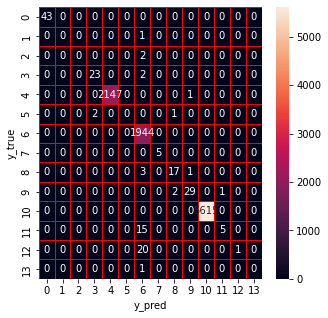

In [45]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [48]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [03:23<00:00, 10.18s/trial, best loss: -0.9987855480214554]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.18367630459662854, 'max_depth': 89.0, 'n_estimators': 80.0}


Accuracy of XGBoost: 0.9987855480214554
Precision of XGBoost: 0.998508829210677
Recall of XGBoost: 0.9987855480214554
F1-score of XGBoost: 0.998591256129916
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.00      0.00      0.00         1
           3       1.00      0.50      0.67         2
           5       0.96      0.96      0.96        25
           9       1.00      1.00      1.00      2148
          10       0.50      0.33      0.40         3
          11       1.00      1.00      1.00      1944
          14       1.00      1.00      1.00         5
          15       0.95      1.00      0.98        21
          17       1.00      1.00      1.00        32
          18       1.00      1.00      1.00      5615
          20       1.00      1.00      1.00        20
          21       0.94      0.71      0.81        21
          22       0.00      0.00      0.00         1

    accuracy                   

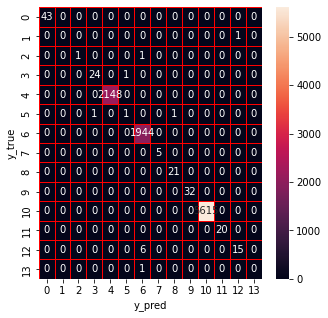

In [49]:
xg = xgb.XGBClassifier(learning_rate= 0.18367630459662854, n_estimators = 80, max_depth = 89)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [66]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### 随机森林 99.84%，调参后99.86%

Accuracy of RF: 0.9984817813765182
Precision of RF: 0.99833354647137
Recall of RF: 0.9984817813765182
F1-score of RF: 0.9984009544980778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           5       0.91      0.83      0.87        24
           9       1.00      1.00      1.00      2145
          10       0.33      0.40      0.36         5
          11       1.00      1.00      1.00      1945
          14       1.00      1.00      1.00         5
          15       0.95      1.00      0.98        21
          17       1.00      1.00      1.00        33
          18       1.00      1.00      1.00      5615
          20       1.00      1.00      1.00        20
          21       0.85      0.85      0.85        20
          22       1.00      1.00      1.00         1

    accuracy                           1.00      98

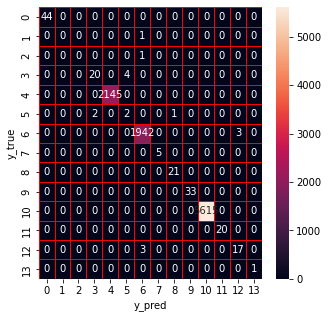

In [99]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [59]:
rf.n_features_

10

In [55]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 10, 1), #这里改成了10 max_features 必须<=n_features
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:37<00:00,  1.87s/trial, best loss: -0.9988867523530007]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 36.0, 'max_features': 8.0, 'min_samples_leaf': 2.0, 'min_samples_split': 7.0, 'n_estimators': 133.0}


Accuracy of RF: 0.9986843436899099
Precision of RF: 0.9981531947867041
Recall of RF: 0.9986843436899099
F1-score of RF: 0.9983933107572553
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         2
           5       0.93      1.00      0.96        25
           9       1.00      1.00      1.00      2148
          10       0.00      0.00      0.00         3
          11       1.00      1.00      1.00      1944
          14       1.00      1.00      1.00         5
          15       0.95      1.00      0.98        21
          17       1.00      1.00      1.00        32
          18       1.00      1.00      1.00      5615
          20       1.00      0.95      0.97        20
          21       0.88      0.71      0.79        21
          22       0.00      0.00      0.00         1

    accuracy                           1.00      

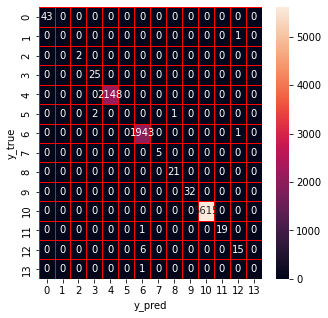

In [56]:
rf_hpo = RandomForestClassifier(n_estimators = 133, min_samples_leaf = 2, max_depth = 36, min_samples_split = 7, max_features = 8, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [57]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

### 决策树 99.72%，调参后99.76%

Accuracy of DT: 0.9972672064777328
Precision of DT: 0.9974766595174336
Recall of DT: 0.9972672064777328
F1-score of DT: 0.9973215592009568
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       0.00      0.00      0.00         1
           3       0.50      1.00      0.67         1
           5       0.92      0.92      0.92        24
           9       1.00      1.00      1.00      2145
          10       0.50      0.40      0.44         5
          11       1.00      0.99      0.99      1945
          14       0.83      1.00      0.91         5
          15       0.91      0.95      0.93        21
          17       0.97      1.00      0.99        33
          18       1.00      1.00      1.00      5615
          20       1.00      1.00      1.00        20
          21       0.62      0.80      0.70        20
          22       0.50      1.00      0.67         1

    accuracy                           1.00      

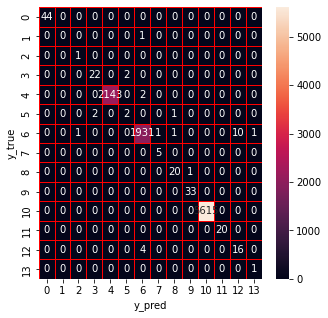

In [100]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [73]:
dt.n_features_

10

In [67]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 10, 1), # 20 改成 10
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:02<00:00, 21.09trial/s, best loss: -0.9984817813765182]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 30.0, 'max_features': 8.0, 'min_samples_leaf': 5.0, 'min_samples_split': 5.0}


Accuracy of DT: 0.997672300374456
Precision of DT: 0.9971246888939852
Recall of DT: 0.997672300374456
F1-score of DT: 0.997352025235049
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         2
           5       0.92      0.96      0.94        25
           9       1.00      1.00      1.00      2148
          10       0.00      0.00      0.00         3
          11       0.99      1.00      1.00      1944
          14       1.00      1.00      1.00         5
          15       0.95      0.86      0.90        21
          17       0.89      1.00      0.94        32
          18       1.00      1.00      1.00      5615
          20       0.94      0.80      0.86        20
          21       0.82      0.67      0.74        21
          22       0.00      0.00      0.00         1

    accuracy                           1.00      988

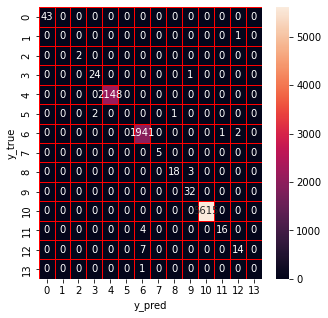

In [50]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 5, max_depth = 30, min_samples_split = 5, max_features = 8, criterion = 'entropy')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [52]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

### 极限树 99.84%，调参后99.85%

Accuracy of ET: 0.9984819350268191
Precision of ET: 0.9982066089290029
Recall of ET: 0.9984819350268191
F1-score of ET: 0.9982827826259653
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.00      0.00      0.00         1
           3       1.00      0.50      0.67         2
           5       0.96      0.96      0.96        25
           9       1.00      1.00      1.00      2148
          10       0.50      0.33      0.40         3
          11       0.99      1.00      1.00      1944
          14       1.00      1.00      1.00         5
          15       0.95      1.00      0.98        21
          17       1.00      1.00      1.00        32
          18       1.00      1.00      1.00      5615
          20       1.00      0.90      0.95        20
          21       0.94      0.71      0.81        21
          22       0.00      0.00      0.00         1

    accuracy                           1.00      

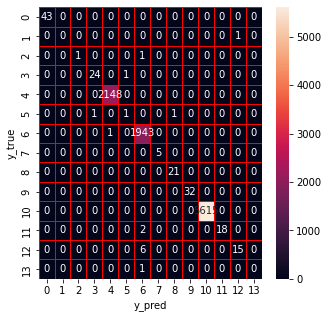

In [59]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [72]:
et.n_features_

10

In [61]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 10, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:26<00:00,  1.32s/trial, best loss: -0.9985831393583645]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 41.0, 'max_features': 9.0, 'min_samples_leaf': 2.0, 'min_samples_split': 2.0, 'n_estimators': 184.0}


Accuracy of ET: 0.9985831393583645
Precision of ET: 0.9983449128948576
Recall of ET: 0.9985831393583645
F1-score of ET: 0.9983865750881021
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         2
           5       0.96      1.00      0.98        25
           9       1.00      1.00      1.00      2148
          10       1.00      0.33      0.50         3
          11       1.00      1.00      1.00      1944
          14       1.00      1.00      1.00         5
          15       0.95      1.00      0.98        21
          17       1.00      1.00      1.00        32
          18       1.00      1.00      1.00      5615
          20       1.00      0.90      0.95        20
          21       0.88      0.71      0.79        21
          22       0.00      0.00      0.00         1

    accuracy                           1.00      

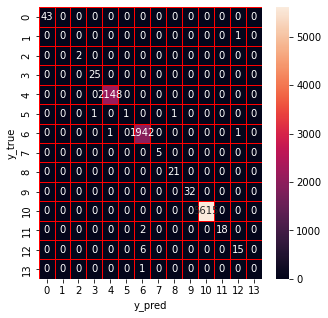

In [63]:
et_hpo = ExtraTreesClassifier(n_estimators = 184, min_samples_leaf = 2, max_depth = 41, min_samples_split = 2, max_features = 9, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [64]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Stacking

In [67]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
    'RandomForest': rf_train.ravel(),
    'ExtraTrees': et_train.ravel(),
    'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,9,9,9,9
1,9,9,9,9
2,11,11,11,11
3,18,18,18,18
4,18,18,18,18


In [68]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [69]:
dt_train.shape

(39520, 1)

In [71]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9987855480214554
Precision of Stacking: 0.998508829210677
Recall of Stacking: 0.9987855480214554
F1-score of Stacking: 0.998591256129916
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.00      0.00      0.00         1
           3       1.00      0.50      0.67         2
           5       0.96      0.96      0.96        25
           9       1.00      1.00      1.00      2148
          10       0.50      0.33      0.40         3
          11       1.00      1.00      1.00      1944
          14       1.00      1.00      1.00         5
          15       0.95      1.00      0.98        21
          17       1.00      1.00      1.00        32
          18       1.00      1.00      1.00      5615
          20       1.00      1.00      1.00        20
          21       0.94      0.71      0.81        21
          22       0.00      0.00      0.00         1

    accuracy               

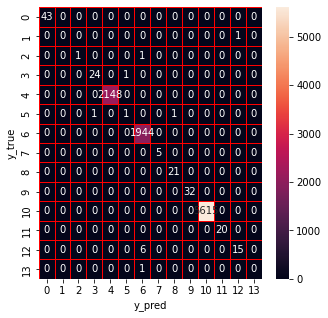

In [72]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [104]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [01:36<00:00,  4.83s/trial, best loss: -0.9987855480214554]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.6428693239698611, 'max_depth': 88.0, 'n_estimators': 70.0}


Accuracy of XGBoost: 0.9987855480214554
Precision of XGBoost: 0.998508829210677
Recall of XGBoost: 0.9987855480214554
F1-score of XGBoost: 0.998591256129916
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.00      0.00      0.00         1
           3       1.00      0.50      0.67         2
           5       0.96      0.96      0.96        25
           9       1.00      1.00      1.00      2148
          10       0.50      0.33      0.40         3
          11       1.00      1.00      1.00      1944
          14       1.00      1.00      1.00         5
          15       0.95      1.00      0.98        21
          17       1.00      1.00      1.00        32
          18       1.00      1.00      1.00      5615
          20       1.00      1.00      1.00        20
          21       0.94      0.71      0.81        21
          22       0.00      0.00      0.00         1

    accuracy                   

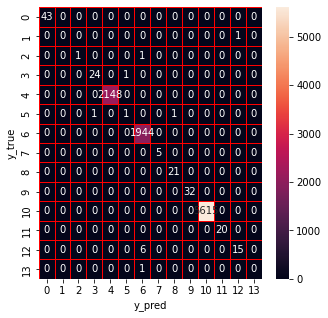

In [105]:
xg = xgb.XGBClassifier(learning_rate= 0.6428693239698611, n_estimators = 70, max_depth = 88)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS 后面这些我内存不够没跑完 让硕试一下应该问题不大

### Generate the port-scan datasets for unknown attack detection

In [73]:
df=pd.read_csv('./data/cup99_sample_km.csv')

In [75]:
df.label.value_counts()

18    28073
9     10740
11     9722
0       214
17      159
5       124
15      107
21      105
20       98
14       26
10       15
3        10
22        3
1         3
6         2
Name: label, dtype: int64

In [76]:
df1 = df[df['label'] != 5]
df1['label'][df1['label'] > 0] = 1
df1.to_csv('./data/cup99_sample_km_without_portscan.csv',index=0)

In [78]:
df2 = df[df['label'] == 5]
df2['label'][df2['label'] == 5] = 1
df2.to_csv('./data/cup99_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [79]:
df1 = pd.read_csv('./data/cup99_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/cup99_sample_km_portscan.csv')

In [81]:
features = df1.drop(['label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [83]:
df1.label.value_counts()

1    49063
0      214
Name: label, dtype: int64

In [84]:
df2.label.value_counts()

1    124
Name: label, dtype: int64

In [85]:
df2p=df1[df1['label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [87]:
df2.label.value_counts()

1    124
0     15
Name: label, dtype: int64

In [88]:
df = df1.append(df2)

In [90]:
X = df.drop(['label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

1    49187
0      229
dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [91]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [92]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [93]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [94]:
X_fs = df[fs].values

In [95]:
X_fs.shape

(49416, 34)

In [96]:
X_fs

array([[-0.01064681, -0.04385575, -0.0240171 , ..., -0.24784907,
        -0.46400574,  0.34420613],
       [-0.01064681, -0.04385575, -0.0240171 , ..., -0.24784907,
        -0.46400574, -1.44332516],
       [-0.01064681, -0.04385575, -0.0240171 , ..., -0.24784907,
        -0.46400574,  0.34420613],
       ...,
       [ 0.80556718,  2.54581436,  0.22582265, ..., -0.24784907,
        -0.46400574,  0.34420613],
       [ 0.80556718,  2.54581436,  0.22582265, ..., -0.24784907,
        -0.46400574,  0.34420613],
       [ 0.80556718,  2.54581436,  0.22582265, ..., -0.24784907,
        -0.46400574, -1.61580625]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [98]:
from FCBF_Module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [99]:
X_fss = fcbf.fit_transform(X_fs,y)

In [100]:
X_fss.shape

(49416, 20)

In [101]:
X_fss

array([[-0.01503897, -0.04385575, -0.24934295, ...,  0.34420613,
         0.88287752, -0.53858077],
       [-0.01503897, -0.04385575, -0.24934295, ..., -1.44332516,
         0.88287752, -0.53858077],
       [-0.01503897, -0.04385575, -0.24934295, ...,  0.34420613,
         0.88287752, -0.53858077],
       ...,
       [ 2.10838582,  2.54581436, -0.0754717 , ...,  0.34420613,
        -1.17982155, -0.53858077],
       [ 2.10838582,  2.54581436, -0.0754717 , ...,  0.34420613,
        -1.18388199, -0.53858077],
       [ 2.10838582,  2.54581436, -0.03200389, ..., -1.61580625,
        -1.17170069, -0.53858077]])

####  kernel principal component analysis (KPCA)

In [102]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

MemoryError: Unable to allocate 18.2 GiB for an array with shape (49416, 49416) and data type float64

### Train-test split after feature selection

In [ ]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [ ]:
pd.Series(y_train).value_counts()

0    18225
1     7320
dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_sample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

1    18225
0    18225
dtype: int64

In [ ]:
pd.Series(y_test).value_counts()

1    1255
0    1255
dtype: int64

### Apply the cluster labeling (CL) k-means method

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [ ]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [ ]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.58      0.69      0.63      1255
           1       0.62      0.51      0.56      1255

    accuracy                           0.60      2510
   macro avg       0.60      0.60      0.60      2510
weighted avg       0.60      0.60      0.60      2510

0.5984063745019921
[[864 391]
 [617 638]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [ ]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.6972111553784861
43 0.7127490039840637
43 0.399203187250996
43 0.47051792828685257
32 0.653784860557769
20 0.34860557768924305
16 0.9195219123505977
5 0.4370517928286853
15 0.6729083665338645
25 0.7063745019920319
2 0.47808764940239046
50 0.4199203187250996


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


50 0.39282868525896414
17 0.42828685258964144


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


16 0.6992031872509961


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


16 0.3737051792828685


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


50 0.6250996015936255
9.127083539962769
Best score=0.9195
Best parameters: n_clusters=16


In [ ]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

23 0.34422310756972113
15 0.6685258964143427
46 0.450199203187251
15 0.4896414342629482
29 0.6824701195219124
36 0.3888446215139442
22 0.35776892430278884
25 0.34860557768924305
42 0.41832669322709165
27 0.47051792828685257
26 0.39402390438247015
25 0.6824701195219124
33 0.3848605577689243
19 0.7191235059760956
6 0.5824701195219123
21 0.6697211155378486
24 0.451394422310757
37 0.4681274900398406
14 0.47250996015936253
21 0.8434262948207172
100%|███████████████████████████████████████████████| 20/20 [00:06<00:00,  2.87trial/s, best loss: 0.15657370517928282]
Random Forest: Hyperopt estimated optimum {'n_clusters': 21.0}


In [ ]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1255
           1       0.91      0.99      0.95      1255

    accuracy                           0.95      2510
   macro avg       0.95      0.95      0.94      2510
weighted avg       0.95      0.95      0.94      2510

0.9450199203187251
[[1127  128]
 [  10 1245]]


### Apply the CL-k-means model with biased classifiers

In [ ]:
# needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)

More details are in the paper